### Titanic 생존자 예측 모델 생성

* 프롬프트에 지시사항을 입력하여 AI의 도움을 받아 작성하였습니다

#### 모델의 예측 성능을 높이기 위해 다음과 같은 과정을 추가

1. Age 구간화(AgeGroup), Name에서 호칭 추출
2. 호칭별(Mr, Miss 등) 평균 나이로 Age 결측치 채우기
3. 가족 크기(FamilySize) 생성
4. 하이퍼파라미터 수정 - 여러 모델 중 성능이 좋았던 '랜덤 포레스트'의 단일 모델의 속성(나무 개수, 깊이 등)을 수정


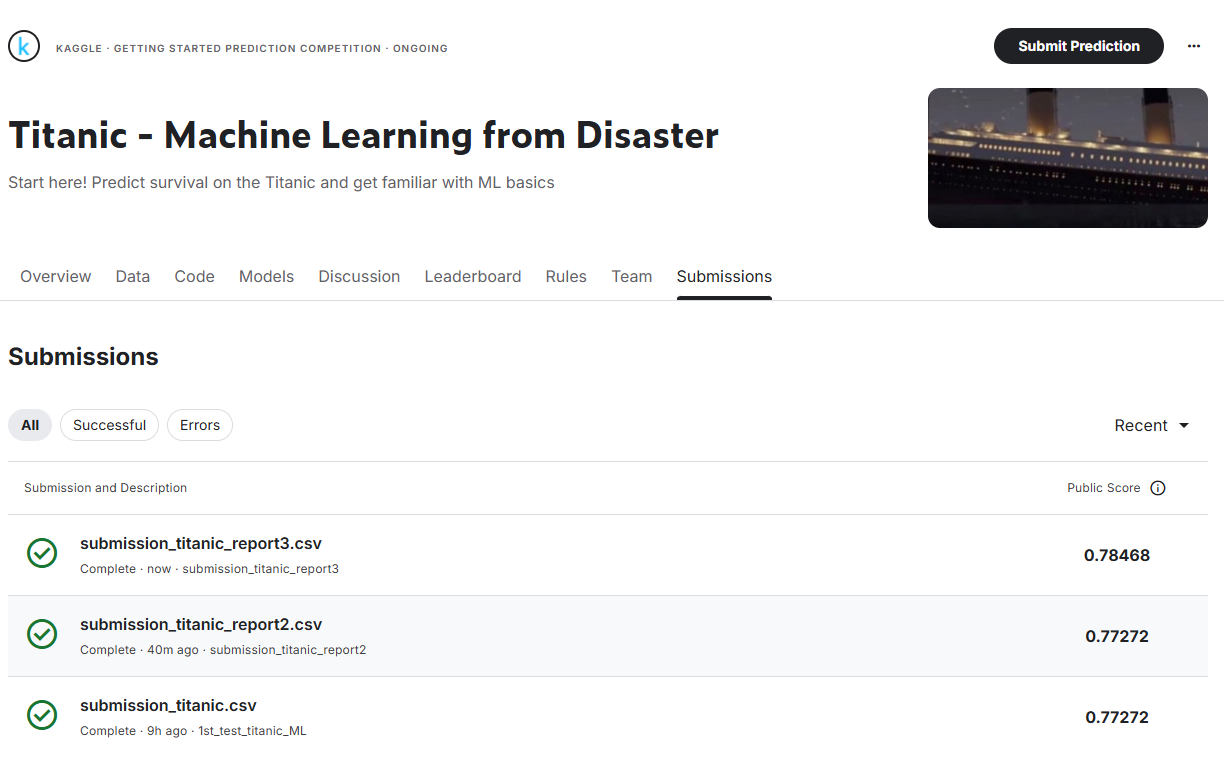

## 1. 데이터 로드 및 EDA (탐색적 데이터 분석)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
train_df = pd.read_csv('data/titanic/train.csv')
test_df = pd.read_csv('data/titanic/test.csv')

print("--- Train Data Info ---")
print(train_df.info())
print("\n--- Test Data Info ---")
print(test_df.info())

# 기본적인 데이터 통계 정보 확인
display(train_df.describe())


--- Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

--- Test Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 2. 데이터 전처리 및 특성 엔지니어링

- **Missing Values**: Age, Embarked, Fare 결측치 처리
- **Name**: 호칭(Title) 추출 및 그룹화
- **Age**: 구간화(Binning) 및 스케일링
- **Encoding**: 범주형 데이터 원-핫 인코딩

In [14]:
# 데이터 합치기 (전처리를 일관되게 적용하기 위함)
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# 1. Name에서 호칭(Title) 추출
all_df['Title'] = all_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 귀족 및 드문 호칭 정리
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
all_df['Title'] = all_df['Title'].replace(rare_titles, 'Rare')
all_df['Title'] = all_df['Title'].replace('Mlle', 'Miss')
all_df['Title'] = all_df['Title'].replace('Ms', 'Miss')
all_df['Title'] = all_df['Title'].replace('Mme', 'Mrs')

print("--- 호칭(Title) 분포 ---")
print(all_df['Title'].value_counts())

# 2. 결측치 처리
# Embarked: 최빈값으로 채움
all_df['Embarked'] = all_df['Embarked'].fillna(all_df['Embarked'].mode()[0])
# Fare: 중앙값으로 채움
all_df['Fare'] = all_df['Fare'].fillna(all_df['Fare'].median())
# 호칭별 평균 나이로 Age 결측치 채우기 (정교한 보정)-호칭(Mr, Miss 등)별 평균값.
all_df['Age'] = all_df['Age'].fillna(all_df.groupby('Title')['Age'].transform('mean'))

# 3. 가족 크기(FamilySize) 생성
all_df['FamilySize'] = all_df['SibSp'] + all_df['Parch'] + 1

# 4. Age 구간화 (Binning) -> 숫자형 범주로 변환 (스케일링 효과)
# Baby: 0~5, Child: 5~12, Teen: 12~18, Student: 18~24, Young: 24~35, Adult: 35~60, Senior: 60+
bins = [-1, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teen', 'Student', 'Young', 'Adult', 'Senior']
all_df['AgeGroup'] = pd.cut(all_df['Age'], bins=bins, labels=labels)

# 5. 불필요한 컬럼 제거
all_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Parch', 'SibSp'], axis=1, inplace=True)

# 6. 범주형 데이터 원-핫 인코딩 (One-Hot Encoding)
all_df = pd.get_dummies(all_df, columns=['Pclass', 'Sex', 'Embarked', 'Title', 'AgeGroup'], drop_first=True)

# 데이터 다시 분리
train_processed = all_df[:len(train_df)]
test_processed = all_df[len(train_df):].drop('Survived', axis=1)

y = train_processed['Survived'].astype(int)
X = train_processed.drop('Survived', axis=1)

print("\n--- 전처리 완료된 데이터 크기 ---")
print(f"X shape: {X.shape}, y shape: {y.shape}")

--- 호칭(Title) 분포 ---
Title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64

--- 전처리 완료된 데이터 크기 ---
X shape: (891, 17), y shape: (891,)


## 3. 8가지 모델 학습 및 성능 순위 출력

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 모델 라이브러리 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# 모델 생성 중 인코딩으로 인한 Trackback log출력
import os
os.environ['PYTHONUTF8'] = '1' # 인코딩 해결책 적용

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 8가지 모델 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gaussian NB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

model_results = {}

# 모델 학습 및 평가
print("--- 모델별 정확도(Accuracy) ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    acc = model.score(X_val, y_val)
    model_results[name] = acc
    print(f"{name}: {acc:.4f}")

# 성능 순위별 정렬
sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

print("\n--- 성능 순위 (Top 4) ---")
for i, (name, score) in enumerate(sorted_models):
    print(f"{i+1}위: {name} ({score:.4f})")

# 학습 완료 후 인코딩 설정 원상복구
del os.environ['PYTHONUTF8'] 

--- 모델별 정확도(Accuracy) ---
Logistic Regression: 0.8045
Decision Tree: 0.8045
Random Forest: 0.8212
SVM: 0.6592
KNN: 0.7821
Gaussian NB: 0.7709
Gradient Boosting: 0.8436
AdaBoost: 0.7933

--- 성능 순위 (Top 4) ---
1위: Gradient Boosting (0.8436)
2위: Random Forest (0.8212)
3위: Logistic Regression (0.8045)
4위: Decision Tree (0.8045)
5위: AdaBoost (0.7933)
6위: KNN (0.7821)
7위: Gaussian NB (0.7709)
8위: SVM (0.6592)


## 4. Top 4 모델 앙상블 (VotingClassifier)

In [5]:
from sklearn.ensemble import VotingClassifier

# 상위 4개 모델 선정
top_4_names = [item[0] for item in sorted_models[:4]]
print(f"선택된 상위 4개 모델: {top_4_names}")

estimators = [(name, models[name]) for name in top_4_names]

# 소프트 보팅 앙상블 모델 생성
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

voting_acc = voting_clf.score(X_val, y_val)
print(f"앙상블 모델(Soft Voting) 정확도: {voting_acc:.4f}")

선택된 상위 4개 모델: ['Gradient Boosting', 'Random Forest', 'Logistic Regression', 'Decision Tree']
앙상블 모델(Soft Voting) 정확도: 0.8380


## 5. 하이퍼파라미터 튜닝 (GridSearchCV)

In [16]:
from sklearn.model_selection import GridSearchCV

# 1. 테스트할 하이퍼파라미터 조합 설정
param_grid = {
    'n_estimators': [100, 200, 300],         # 나무의 개수
    'max_depth': [None, 5, 10, 15],           # 나무의 깊이
    'min_samples_split': [2, 5, 10],          # 노드를 나누기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],            # 리프 노드에 있어야 할 최소 샘플 수
    'criterion': ['gini', 'entropy']          # 불순도 측정 지표
}

# 2. GridSearchCV 객체 생성
# cv=5: 5번의 교차 검증을 통해 평균 성능 측정
# n_jobs=-1: 내 컴퓨터의 모든 CPU 코어를 사용하여 빠르게 계산
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1, 
    verbose=1,
    scoring='accuracy'
)

# 3. 최적 조합 학습 시작
grid_search.fit(X_train, y_train)

# 4. 결과 출력
print("-" * 30)
print(f"최적의 파라미터 조합: {grid_search.best_params_}")
print(f"학습 데이터 최고 정확도: {grid_search.best_score_:.4f}")

# 5. 최적의 모델(best_estimator_)로 검증 데이터(X_test) 평가
best_rf_model = grid_search.best_estimator_
final_accuracy = best_rf_model.score(X_val, y_val)
print(f"최종 검증용 데이터 정확도: {final_accuracy:.4f}")
print("-" * 30)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
------------------------------
최적의 파라미터 조합: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
학습 데이터 최고 정확도: 0.8384
최종 검증용 데이터 정확도: 0.8268
------------------------------


In [17]:
# 앙상블 모델의 가중치(weights) 튜닝
# 4개 모델이므로 가중치 조합을 시도
params = {
    'weights': [
        [1, 1, 1, 1], 
        [2, 1, 1, 1], 
        [1, 2, 1, 1], 
        [1, 1, 2, 1],
        [1, 1, 1, 2]
    ]
}

grid_search = GridSearchCV(voting_clf, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_ensemble = grid_search.best_estimator_
final_acc = best_ensemble.score(X_val, y_val)

print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"튜닝 후 앙상블 모델 정확도: {final_acc:.4f}")

최적의 파라미터: {'weights': [1, 1, 2, 1]}
튜닝 후 앙상블 모델 정확도: 0.8380


## 6. 결과 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_18544\1278184791.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_scores, y=model_names, palette='magma')


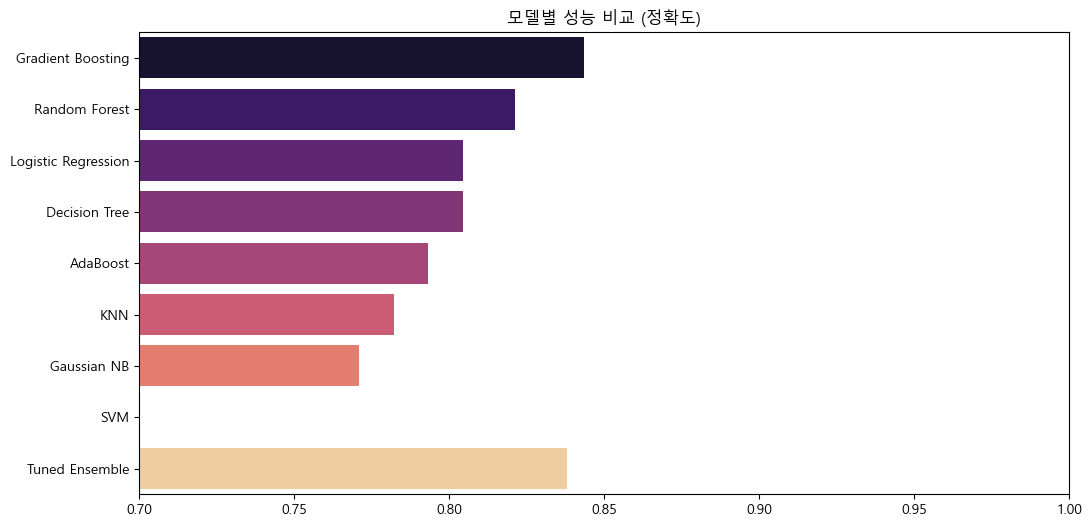

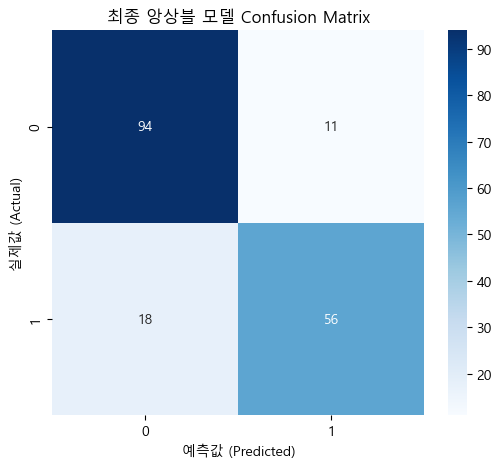

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# sns.set()이나 sns.set_theme()을 사용하면 Matplotlib의 폰트 설정이 초기화 되어 한글깨져서 그래프별 한글 별도 설정
plt.rc('font', family='Malgun Gothic')

# 1. 모델별 성능 비교 그래프
model_names = [item[0] for item in sorted_models]
model_scores = [item[1] for item in sorted_models]

# 앙상블 결과 추가
model_names.append('Tuned Ensemble')
model_scores.append(final_acc)

plt.figure(figsize=(12, 6))
sns.barplot(x=model_scores, y=model_names, palette='magma')
plt.title('모델별 성능 비교 (정확도)')
plt.xlim(0.7, 1.0)
plt.show()

# 2. 혼동 행렬 (Confusion Matrix) 시각화
y_pred_val = best_ensemble.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('최종 앙상블 모델 Confusion Matrix')
plt.xlabel('예측값 (Predicted)')
plt.ylabel('실제값 (Actual)')
plt.show()

## 7. 캐글 제출용 파일 생성

In [21]:
# 테스트 데이터에 대한 예측
test_predictions = best_ensemble.predict(test_processed)

# 원본 test.csv에서 PassengerId 가져오기
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# CSV 파일 저장
submission.to_csv('submission_titanic_report3.csv', index=False)
print("제출 파일 'submission_titanic_report3.csv' 생성이 완료되었습니다.")
print(submission.head())

제출 파일 'submission_titanic_report3.csv' 생성이 완료되었습니다.
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
